**Necessary Imports**

In [ ]:
###
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import VGG16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Vgg16/Model/'
save_path1 = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Vgg16/Weight/'

In [ ]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData.npy")
y_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData.npy")
y_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData.npy")
y_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


**Training Models**

# **Fine Tunning**

In [ ]:
base_model = VGG16(input_shape=(110,110,3), input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

def VGG(seed = None):
    np.random.seed(seed)
    vgg16 = VGG16(weights="imagenet", include_top=False)
    for layer in vgg16.layers[:13]:
        layer.trainable = False
    for layer in vgg16.layers[13:]:
        layer.trainable = True
    y = (vgg16.get_layer("block4_conv3")).output
    mx_y = GlobalMaxPool2D()(y)
    x = BatchNormalization()(mx_y)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(5,activation='softmax')(x)
    model = Model(inputs=vgg16.input, outputs=preds)
    return model

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [ ]:
model_vgg16= VGG()

epochs = 50
opt = Adam(learning_rate=1e-3)
model_vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
print(y_train.shape)

(18123,)


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)


In [ ]:
trainVgg16FT = model_vgg16.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val,y_val_one_hot), epochs=50, callbacks=callbacks)

Epoch 1/50
566/567 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9446
Epoch 1: val_accuracy improved from 0.94907 to 0.95216, saving model to saved_models/model_vgg16.hdf5
567/567 [==============================] - 23s 41ms/step - loss: 0.1569 - accuracy: 0.9446 - val_loss: 0.1462 - val_accuracy: 0.9522 - lr: 2.0000e-04
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9509
Epoch 2: val_accuracy did not improve from 0.95216
567/567 [==============================] - 23s 41ms/step - loss: 0.1359 - accuracy: 0.9509 - val_loss: 0.1693 - val_accuracy: 0.9475 - lr: 2.0000e-04
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9529
Epoch 3: val_accuracy did not improve from 0.95216
567/567 [==============================] - 23s 40ms/step - loss: 0.1279 - accuracy: 0.9529 - val_loss: 0.1620 - val_accuracy: 0.9522 - lr: 2.0000e-04
Epoch 4/50
567/567 [==============================] - ETA:

Saving Model in GDrive

In [ ]:
model_vgg16.save(save_path + 'FineTunedVGG16.h5')
#model_vgg16.save_weights(save_path1 + "Weights_FineTunedVGG16.h5")


In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = model_vgg16.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 1s 32ms/step - loss: 0.1822 - accuracy: 0.9557


Evaluating Model

In [ ]:
from tensorflow.keras.models import load_model
FT_VGG16= load_model(save_path + 'FineTunedVGG16.h5')


26/26 [==============================] - 1s 39ms/step


ValueError: ignored

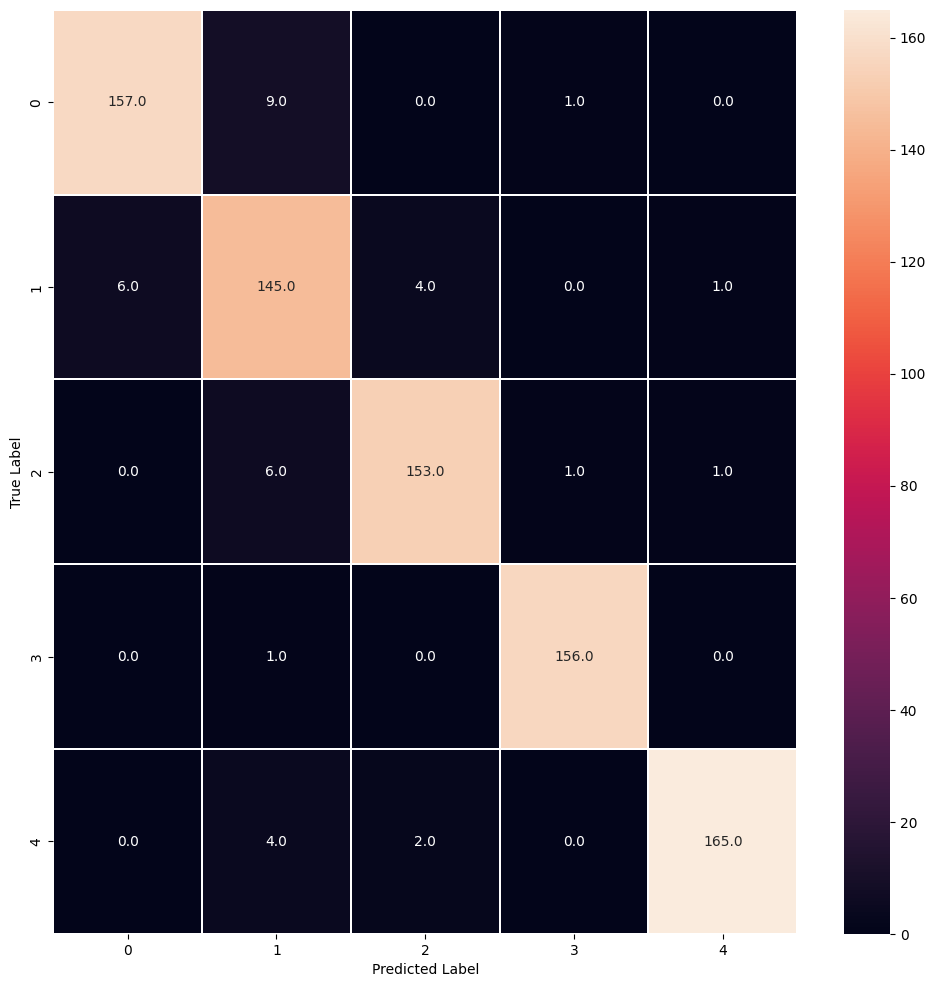

In [ ]:
cancer_classes=np.unique(y_test)
pred = FT_VGG16.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(y_test)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
0,0.940120,0.963190,0.951515,163.000000
1,0.929487,0.878788,0.903427,165.000000
2,0.950311,0.962264,0.956250,159.000000
3,0.993631,0.987342,0.990476,158.000000
4,0.964912,0.988024,0.976331,167.000000
accuracy,0.955665,0.955665,0.955665,0.955665
macro avg,0.955692,0.955922,0.955600,812.000000
weighted avg,0.955466,0.955665,0.955356,812.000000


# Cost Sensitive

In [ ]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_test), class_weight.compute_class_weight('balanced', classes = np.unique(y_test),
                                        y = y_test))) 

class_weights

{0: 0.996319018404908,
 1: 0.9842424242424243,
 2: 1.0213836477987421,
 3: 1.0278481012658227,
 4: 0.9724550898203593}

In [ ]:
modelCS_VGG16=load_model(save_path + 'FineTunedVGG16.h5')
epochs = 50
opt = Adam(learning_rate=1e-3)
modelCS_VGG16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/modelCS_VGG16_CS.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
modelCS_VGG16.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=50, class_weight=class_weights,callbacks=callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9673
Epoch 1: val_accuracy improved from 0.94753 to 0.95679, saving model to saved_models/modelCS_VGG16_CS.hdf5
567/567 [==============================] - 23s 41ms/step - loss: 0.0910 - accuracy: 0.9673 - val_loss: 0.1612 - val_accuracy: 0.9568 - lr: 2.0000e-04
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9727
Epoch 2: val_accuracy did not improve from 0.95679
567/567 [==============================] - 24s 42ms/step - loss: 0.0789 - accuracy: 0.9727 - val_loss: 0.1821 - val_accuracy: 0.9552 - lr: 2.0000e-04
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9736
Epoch 3: val_accuracy did not improve from 0.95679
567/567 [==============================] - 23s 40ms/step - loss: 0.0742 - accuracy: 0.9736 - val_loss: 0.1771 - val_accuracy: 0.9537 - lr: 2.0000e-04
Epoch 4/50
567/567 [==============================] -

In [ ]:
modelCS_VGG16.save(save_path + 'FTCS_VGG16.h5')
#modelCS_VGG16.save_weights(save_path1 + "Weights_FTCS_VGG16.h5")


In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = modelCS_VGG16.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 1s 33ms/step - loss: 0.2019 - accuracy: 0.9594


In [ ]:
CS_VGG16= load_model(save_path + 'FTCS_VGG16.h5')

26/26 [==============================] - 1s 35ms/step


ValueError: ignored

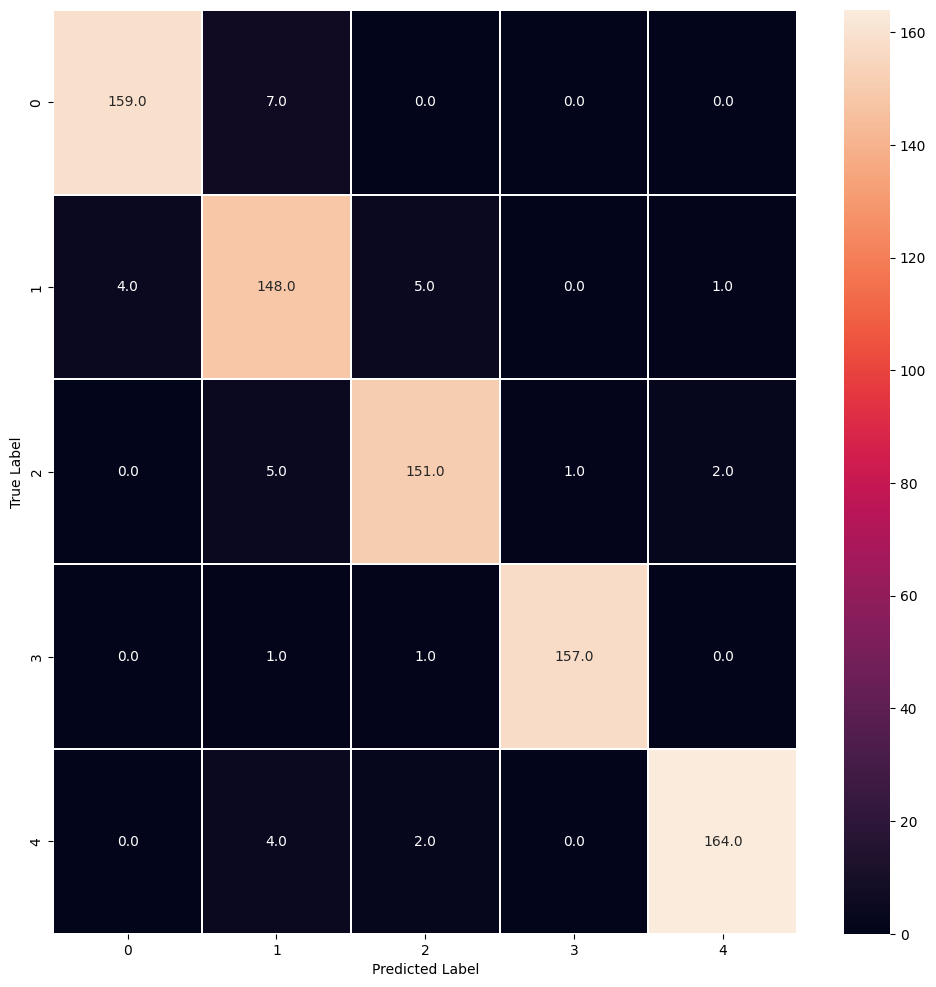

In [ ]:
cancer_classes=np.unique(y_test)
pred = CS_VGG16.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(y_test)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
report12 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report12).transpose()
df12

,precision,recall,f1-score,support
0,0.957831,0.975460,0.966565,163.00000
1,0.936709,0.896970,0.916409,165.00000
2,0.949686,0.949686,0.949686,159.00000
3,0.987421,0.993671,0.990536,158.00000
4,0.964706,0.982036,0.973294,167.00000
accuracy,0.959360,0.959360,0.959360,0.95936
macro avg,0.959271,0.959564,0.959298,812.00000
weighted avg,0.959116,0.959360,0.959116,812.00000
